# Discordance analysis

In this example we will analyse the discordance between gene-trees and species tree for the trees in phylome 15 with two different ways:

1. GeneRax
2. EcceTERA

First load the functions


In [1]:
import os
os.chdir("..")

In [7]:
import analyse_phylome as ap
from ete3 import Tree

outDir = "./out_dir15"
treeFile = "./test_data/best_trees15.txt"
aln_dir = "./test_data/all_algs_15"
sptree = "./test_data/rooted_phylome_15_sp_duptree.txt"

out_sprax = outDir + "/sprax15"

##### GeneRax

"GeneRax is a parallel tool for species tree-aware maximum likelihood based gene family tree inference under gene duplication, transfer, and loss.

It infers gene family trees from their aligned sequences, the mapping between genes and species, and a rooted undated species tree. In addition, it infers the duplication, transfer and loss events that best (in terms of maximum likelihood) reconcile the gene family trees with the species trees.

It accounts for sequence substitutions, gene duplication, gene loss and horizontal gene transfer." [repo here](https://github.com/BenoitMorel/GeneRax)

GeneRax uses raxml parser to read alignment file. This causes an issue as raxml does not accept U (Selenocysteine) that is present in few phylomes. Thus, before creating data you can run the function scan_for_Us() and decide to replace the character with any other (C by default). This will create  copy of the alignment called "id.clean_noUs.fasta" that later will be added to the family file instead of the orginal alignment.

In [3]:
ap.scan_for_Us(aln_dir)

No files contain Us.


To get the data needed we run this function that will create the necessary folders and family file

In [4]:
ap.get_generax_data(treeFile, out_sprax, aln_dir)


then `mpiexec -np processors generax -s /gpfs/projects/bsc40/gmutti/Second_proj/all_phylomes/rooted_phylome_$i\_sp_duptree.txt --seed 42 --families /gpfs/scratch/bsc40/bsc40122/all_generax/families/$i\_generax_family.txt --strategy EVAL --rec-model UndatedDTL --per-family-rates --prefix /gpfs/scratch/bsc40/bsc40122/all_generax/generax_phylome_$i`


In [5]:
out_res = outDir + "/generax_phylome_15"

grax_df = ap.get_generax_df(out_res)

In [6]:
grax_df.head()

,S,SL,D,T,TL,L,Leaf,Index,S_norm,SL_norm,D_norm,T_norm,TL_norm,L_norm
0,27,11,27,24,0,0,79,Phy008FJJ2_341454,0.341772,0.139241,0.341772,0.303797,0.0,0.0
1,21,6,0,11,0,0,33,Phy008FKAG_341454,0.636364,0.181818,0.0,0.333333,0.0,0.0
2,1,0,0,1,0,0,3,Phy008FI76_341454,0.333333,0.0,0.0,0.333333,0.0,0.0
3,9,2,0,1,0,0,11,Phy008FHKT_341454,0.818182,0.181818,0.0,0.090909,0.0,0.0
4,2,0,0,3,0,0,6,Phy008FFXV_341454,0.333333,0.0,0.0,0.5,0.0,0.0


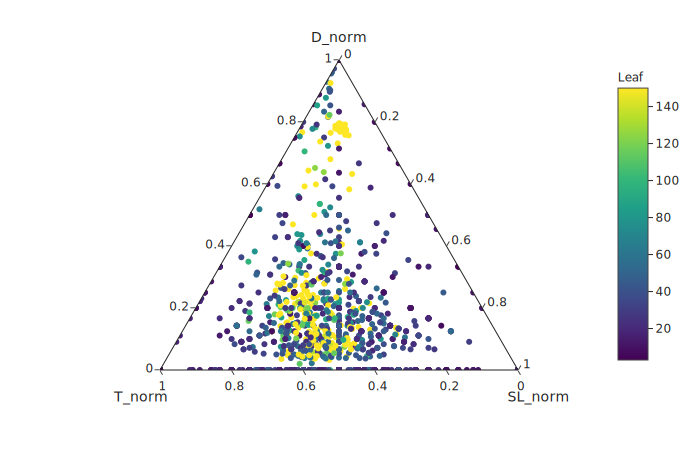

In [7]:
grax_ter = ap.ternary_grax_plot(grax_df, renderer = "svg")

Unlikely, GitHub does not render interctive plotly graph. If the argument renderer is ignored the plot will be interactive.

Eventually you can visualize one of the reconciliated gene tree saved by GeneRax in nhx format.

In [9]:
tree_random = "./out_dir15/generax_phylome_15/reconciliations/Phy008FIW9_341454_reconciliated.nhx"
speclist = "./test_data/speclist_24_08_21.txt"


tree = Tree(tree_random, format=1)

tax_dict = ap.get_tax_dict(tree, speclist)

You may want to add it manually


In [11]:
out_gene = ap.annotate_genetree(tree, tax_dict)

ap.viz_grax_tree(out_gene, show=False, render="./out_dir15/plot_grax_Phy008FIW9.png")

![grax](../out_dir15/plot_grax_Phy008FIW9.png)

Duplication nodes are annotated with a red circle, whereas transfer nodes with a green one and the species involved in the transfer are written in the node. The leaves are colored by species.

Alternatively you may upload the output recphyloxml file [here](http://phylariane.univ-lyon1.fr/recphyloxml/recphylovisu) to get the gene tree reconciled with the species tree.

![recphylo](../out_dir15/plot_grax_Phy008FIW9_rec.svg)

### ecceTERA

In [9]:
ecce_out = "./test_data/ecce_15.out"

In [15]:
ap.get_ecce_data(treeFile, sptree, outDir)

`ecceTERA species.file=/gpfs/projects/bsc40/gmutti/Second_proj/all_phylomes/rooted_phylome_$i\_sp_duptree.txt gene.file=/gpfs/scratch/bsc40/bsc40122/all_ecce/ecce_best_trees$i.txt dated=0 verbose=1 print.newick=1 output.dir=/gpfs/scratch/bsc40/bsc40122/all_ecce/ecce_phylome_$i/ print.reconciliations=1 print.info=1 orthology.output=1 print.newick=1 print.graph=1 > /gpfs/scratch/bsc40/bsc40122/all_ecce/ecce_$i.out`


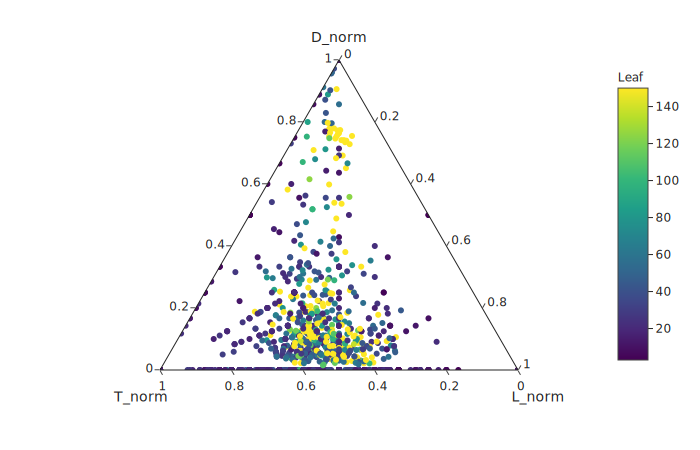

In [10]:
ecce_df = ap.get_ecce_df(treeFile, ecce_out)

ecce_df.head()

ap.ternary_ecce_plot(ecce_df, renderer="svg")

Unluckily, eccetera saves the results of reconciliations losing info on filename. We can find the index of the file of interest and get it however.

In [11]:
ecce_df.index[ecce_df['Index'] == "Phy008FIW9_341454"].tolist()[0] -1 # as index are 0-based

338

The trees may be saved as recphyloxml files by activating recPhyloXML.reconciliation=true and upload it [here](http://phylariane.univ-lyon1.fr/recphyloxml/recphylovisu)